In [1]:
from trajectree.fock_optics.utils import create_vacuum_state
from trajectree.fock_optics.light_sources import light_source, create_TMSV_OP_Dense
from trajectree.fock_optics.devices import ry, global_phase
from trajectree.fock_optics.measurement import create_threshold_POVM_OP_Dense, rotate_and_measure, create_PNR_POVM_OP_Dense
from trajectree.fock_optics.outputs import print_quantum_state, read_quantum_state
from trajectree.fock_optics.noise_models import general_mixed_bs_noise_model, depolarizing_operators, two_qubit_depolarizing_channel

from trajectree.trajectory import trajectory_evaluator, quantum_channel

import numpy as np
from scipy import sparse as sp
import qutip as qt
from numpy import sqrt
import time
import copy
from quimb.tensor.tensor_arbgeom import tensor_network_apply_op_vec #type: ignore
from quimb.tensor import MatrixProductOperator as mpo #type: ignore

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from functools import lru_cache
from IPython.display import HTML
import multiprocessing


## Common functions

In [2]:
def create_perfect_bell_state(D=3, error_tolerance = 1e-10):
    # Defining the control and target inputs here
    a_dag = qt.create(D).full()
    I = qt.identity(D).full()

    a_H = np.kron(a_dag, I)
    a_V = np.kron(I, a_dag)

    # Testing the case with only one MPS for both control and target
    vacuum = create_vacuum_state(num_modes=4, N=D)
    pure_EPPS_operator = 1/sqrt(2) * (np.kron(a_H, a_H) + np.kron(a_V, a_V))
    pure_EPPS_operator_MPO = mpo.from_dense(pure_EPPS_operator, dims = D, sites = (0,1,2,3), L=4, tags="ideal_state")    
    psi = tensor_network_apply_op_vec(pure_EPPS_operator_MPO, vacuum, compress=True, contract = True, cutoff = error_tolerance)
    return psi

def create_POVMs(efficiency, D, PNR = False):
    if not PNR:
        POVM_0 = create_threshold_POVM_OP_Dense(efficiency, 0, D)
        POVM_1 = create_threshold_POVM_OP_Dense(efficiency, 1, D)
    else:
        POVM_0 = create_PNR_POVM_OP_Dense(efficiency, 0, D, debug = False)
        POVM_1 = create_PNR_POVM_OP_Dense(efficiency, 1, D, debug = False)

    POVM_H = sp.csr_matrix( np.kron(POVM_1, POVM_0) ) # H detector clicks, V does not
    POVM_V = sp.csr_matrix( np.kron(POVM_0, POVM_1) ) # V detector clicks, H does not
    POVM_N = sp.csr_matrix( np.kron(POVM_0, POVM_0) ) # No detector clicks
    POVM_B = sp.csr_matrix( np.kron(POVM_1, POVM_1) ) # Both detectors click 

    return POVM_H, POVM_V, POVM_N, POVM_B


## CGLMP functions:


In [3]:
def CGLMP_witness(d, N, D, efficiency):
    """
        Generates the witness operator for CGLMP inequality for given measurement operators.
        
        :d: Number of outcomes of measurment operators
        :N: Number of measurment settings
        :alice_meas_ops: 2D list (with dimensions [N,d]) of operators for Alice. alice_meas_ops[n,i] is the operator for the nth measurment setting producing the ith outcome. 
        :bob_meas_ops: 2D list (with dimensions [N,d]) of operators for Bob. bob_meas_ops[n,i] is the operator for the nth measurment setting producing the ith outcome. 
        
    """

    alice_meas_ops, bob_meas_ops = CHSH_optimal_meas_ops(efficiency, D)

    op = 0

    for a in range(d):
        for b in range(d):
            if a >= b:
                op += np.kron(alice_meas_ops[N-1][a], bob_meas_ops[0][b])

    for n in range(N):
        for a in range(d):
            for b in range(d):
                if a < b:
                    op += np.kron(alice_meas_ops[n][a], bob_meas_ops[n][b])

    for n in range(N-1):
        for a in range(d):
            for b in range(d):
                if b < a:
                    op += np.kron(alice_meas_ops[n][a], bob_meas_ops[n+1][b])

    CGLMP_op_MPO = mpo.from_dense(op, dims = D, sites = (0,1,2,3), L=4, tags="meas op")
    return quantum_channel(N = D, num_modes = 4, formalism = "closed", unitary_op = CGLMP_op_MPO, backend = "tensor", name = "expectation val")


def CHSH_optimal_meas_ops(efficiency, D):

    projection_ops = create_POVMs(efficiency, D, PNR = False)

    I = np.eye(D**2)
    ry_pi_4 = ry(np.pi/4, D, return_unitary=True)
    ry_pi_2 = ry(np.pi/2, D, return_unitary=True)

    alice_settings = [I, ry_pi_2]
    bob_settings = [ry_pi_4, ry_pi_4 @ ry_pi_2]

    alice_meas_ops = [[setting @ povm @ setting.conj().T for povm in projection_ops] for setting in alice_settings]
    bob_meas_ops = [[setting @ povm @ setting.conj().T for povm in projection_ops] for setting in bob_settings]

    return alice_meas_ops, bob_meas_ops

## CHSH functions:

In [4]:
def CHSH_projector(efficiency, N, PNR=False):
    measurements = [ 1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1,  1, -1,  1,  1]
                 # [HH, HV, HN, HB, VH, VV, VN, VB, NH, NV, NN, NB, BH, BV, BN, BB]
    POVM_H, POVM_V, POVM_N, POVM_B = create_POVMs(efficiency, N, PNR)
    E = 0
    POVM_ops = [POVM_H, POVM_V, POVM_N, POVM_B]
    for i in range(len(POVM_ops)):
        for j in range(len(POVM_ops)):
            E += measurements[4*i+j] * sp.kron(POVM_ops[i], POVM_ops[j]) 
    return E



def CHSH_witness(efficiency, D, PNR = False):

    # First, we define some constants that we will be using for the experiment. 
    I = np.eye(D**2)
    ry_pi_4 = ry(np.pi/4, D, return_unitary=True)
    ry_pi_2 = ry(np.pi/2, D, return_unitary=True)

    op_00 = sp.csr_matrix( np.kron(I, ry_pi_4) @ np.kron(ry_pi_2, I) )
    op_01 = sp.csr_matrix( np.kron(I, ry_pi_4) @ np.kron(ry_pi_2, ry_pi_2) )
    op_10 = sp.csr_matrix( np.kron(I, ry_pi_4) @ np.kron(I, I) )
    op_11 = sp.csr_matrix( np.kron(I, ry_pi_4) @ np.kron(I, ry_pi_2) )

    CHSH_projector_op = CHSH_projector(efficiency, D, PNR)

    witness = op_00 @ CHSH_projector_op @ op_00.conj().T
    witness += op_01 @ CHSH_projector_op @ op_01.conj().T
    witness += op_10 @ CHSH_projector_op @ op_10.conj().T
    witness -= op_11 @ CHSH_projector_op @ op_11.conj().T

    CHSH_op_MPO = mpo.from_dense(witness.toarray(), dims = D, sites = (0,1,2,3), L=4, tags="meas op")
    return quantum_channel(N = D, num_modes = 4, formalism = "closed", unitary_op = CHSH_op_MPO, backend = "tensor", name = "expectation val")



First, we validate the correctness of the simulation by performing the standard CHSH experiment. 

In [ ]:
def initialize_simulation_depolarization(d, N, efficiency, depolarizing_probability, D, inequality = "CHSH"):
    quantum_channel_list = []

    depol_channel = depolarizing_operators(depolarizing_probability, D)
    quantum_channel_list.append(quantum_channel(N = D, num_modes = 4, formalism = "kraus", kraus_ops_tuple = ((0,1), depol_channel), name = "depol"))
    quantum_channel_list.append(quantum_channel(N = D, num_modes = 4, formalism = "kraus", kraus_ops_tuple = ((2,3), depol_channel), name = "depol"))

    if inequality == "CGLMP":
        observable_list = [CGLMP_witness(d, N, D, efficiency)]
    elif inequality == "CHSH":
        observable_list = [CHSH_witness(efficiency, D)]

    return trajectory_evaluator(quantum_channel_list, calc_expectation = True, observable_ops = observable_list)

Now, we use the same initial entangled state mixed with thermal noise to analyze its robustness against the CHSH and CGLMP inequalities

done with 0.0
done with 0.07142857142857142
done with 0.14285714285714285
done with 0.21428571428571427
done with 0.2857142857142857
done with 0.3571428571428571
done with 0.42857142857142855
done with 0.5
done with 0.5714285714285714
done with 0.6428571428571428
done with 0.7142857142857142
done with 0.7857142857142857
done with 0.8571428571428571
done with 0.9285714285714285
done with 1.0


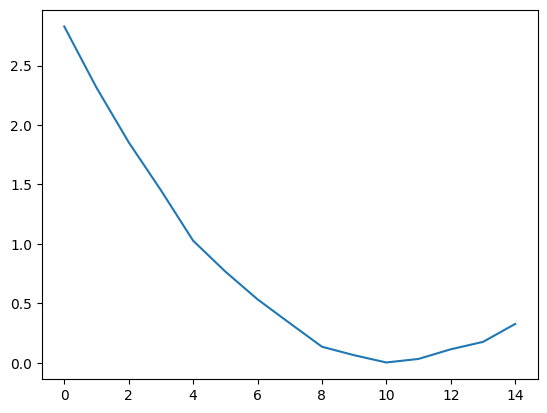

In [ ]:
D=4 # Local Hilbert space dimension
d = 2
N = 2

dark_count_rate = 1e-5
efficiency = 1

bell_state = create_perfect_bell_state(D=D)

error_tolerance = 1e-10

num_iterations = 5000
depolarizing_probabilities = np.linspace(0,1,15)
evs = []
for depolarizing_probability in depolarizing_probabilities:
    ev = 0
    t_eval = initialize_simulation_depolarization(d, N, efficiency, depolarizing_probability = depolarizing_probability, D=D, inequality = "CHSH")
    print("done with", depolarizing_probability)
    for i in range(num_iterations):
        ev += t_eval.perform_simulation(psi = bell_state, error_tolerance=error_tolerance)
    evs.append(ev/num_iterations)
plt.plot(evs)

Now, we perform the same experiment for the full simulation

In [5]:
def initialize_simulation(dark_count_rates, efficiencies, depolarizing_probability, d, N, D, inequality = "CHSH"):
    quantum_channel_list = []

    damping_and_noise_channel = general_mixed_bs_noise_model(dark_count_rate = dark_count_rates[0], eta = efficiencies[0], N = D)
    quantum_channel_list.append(quantum_channel(N = D, num_modes = 4, formalism = "kraus", kraus_ops_tuple = ((0,), damping_and_noise_channel), name = "loss+noise"))
    
    damping_and_noise_channel = general_mixed_bs_noise_model(dark_count_rate = dark_count_rates[1], eta = efficiencies[1], N = D)
    quantum_channel_list.append(quantum_channel(N = D, num_modes = 4, formalism = "kraus", kraus_ops_tuple = ((1,), damping_and_noise_channel), name = "loss+noise"))
    
    damping_and_noise_channel = general_mixed_bs_noise_model(dark_count_rate = dark_count_rates[2], eta = efficiencies[2], N = D)
    quantum_channel_list.append(quantum_channel(N = D, num_modes = 4, formalism = "kraus", kraus_ops_tuple = ((2,), damping_and_noise_channel), name = "loss+noise"))
    
    damping_and_noise_channel = general_mixed_bs_noise_model(dark_count_rate = dark_count_rates[3], eta = efficiencies[3], N = D)
    quantum_channel_list.append(quantum_channel(N = D, num_modes = 4, formalism = "kraus", kraus_ops_tuple = ((3,), damping_and_noise_channel), name = "loss+noise"))

    depol_channel = depolarizing_operators(depolarizing_probability, D)
    quantum_channel_list.append(quantum_channel(N = D, num_modes = 4, formalism = "kraus", kraus_ops_tuple = ((0,1), depol_channel), name = "depol"))
    quantum_channel_list.append(quantum_channel(N = D, num_modes = 4, formalism = "kraus", kraus_ops_tuple = ((2,3), depol_channel), name = "depol"))

    if inequality == "CGLMP":
        observable_list = [CGLMP_witness(d=d, N=N, D=D, efficiency=1)]
    elif inequality == "CHSH":
        observable_list = [CHSH_witness(efficiency=1, D=D)]

    return trajectory_evaluator(quantum_channel_list, calc_expectation = True, observable_ops = observable_list)

def run_simulation(dark_count_rates, efficiencies, depolarizing_probability, d, N, D, num_iterations, inequality = "CHSH"):
    ev = 0
    t_eval = initialize_simulation(dark_count_rates, efficiencies, depolarizing_probability, d, N, D, inequality = inequality)
    # print("done with", depolarizing_probability)
    for _ in range(num_iterations):
        ev += t_eval.perform_simulation(psi = bell_state, error_tolerance=error_tolerance)
    print("done with", depolarizing_probability)
    return ev/num_iterations

done with 0.5
done with 0.14285714285714285
done with 0.8571428571428571
done with 0.21428571428571427
done with 0.07142857142857142
done with 0.5714285714285714
done with 0.3571428571428571
done with 1.0
done with 0.2857142857142857
done with 0.0
done with 0.7857142857142857
done with 0.9285714285714285
done with 0.6428571428571428
done with 0.7142857142857142
done with 0.42857142857142855


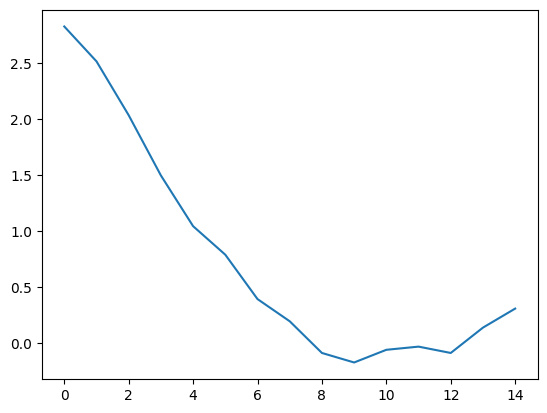

In [8]:
D=4 # Local Hilbert space dimension
d=4 # Number of measurement outcomes
N=2 # Number of measurement settings
dark_count_rates = [1e-5] * 4
efficiencies = [0.999]*4
inequality = "CHSH"

error_tolerance = 1e-10
num_iterations = 100
depolarizing_probabilities = np.linspace(0,1,15)

bell_state = create_perfect_bell_state(D=D)
# vacuum = create_vacuum_state(num_modes=8, N=D)
# bell_state = light_source(vacuum, D, mean_photon_num, 8, error_tolerance, compress=True, contract=True)[0]

with multiprocessing.Pool() as pool:
    evs = pool.starmap(run_simulation, [(dark_count_rates, efficiencies, depolarizing_probability, d, N, D, num_iterations, inequality) for depolarizing_probability in depolarizing_probabilities])

plt.plot(evs)

In [ ]:

def process_item(item):
    # This function defines the work done in one loop iteration
    time.sleep(0.1) # Simulate some work
    return item * 2

items = [1,2,3]
with multiprocessing.Pool(processes=4) as pool:
    results = pool.map(process_item, items)

In [27]:
results

[2, 4, 6]

CHSH Robustness: 0.5773251628602507
CGLMP Robustness: 0.3915343233572105


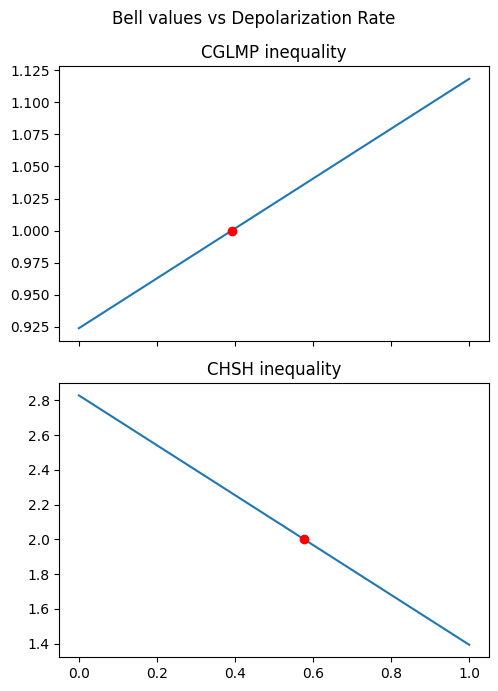

In [8]:
fig, axs = plt.subplots(2,1, figsize=(5, 7), sharex = True)
fig.suptitle('Bell values vs Depolarization Rate')
axs[0].plot(depolarization_rate_list, np.real(CGLMP_Bell_values))
axs[0].set_title("CGLMP inequality")
if CGLMP_robustness.real >=0 and CGLMP_robustness.real <= 1:
    axs[0].plot(CGLMP_robustness.real, 1, 'ro')

axs[1].plot(depolarization_rate_list, np.real(CHSH_Bell_values))
axs[1].set_title("CHSH inequality")
if CHSH_robustness.real >=0 and CHSH_robustness.real <= 1:
    axs[1].plot(CHSH_robustness.real, 2, 'ro')
fig.tight_layout()

print("CHSH Robustness:", CHSH_robustness.real)
print("CGLMP Robustness:", CGLMP_robustness.real)

Now, we compare multiple parameters with each other:

In [ ]:
def compare_inequalities(D, d, N, mean_photon_num, thermal_mpn, efficiency, depolarization_rate_list):
    # vacuum = create_vacuum_state(num_modes=8, N=D)
    # bell_state = light_source(vacuum, D, mean_photon_num, 8, error_tolerance, compress=True, contract=True)[1].toarray()
    bell_state = create_perfect_bell_state(D=D).to_dense()

    bell_dm = bell_state @ bell_state.T.conj()

    two_mode_thermal_noise = np.kron(qt.thermal_dm(D, thermal_mpn, method='operator').full(), qt.thermal_dm(D, thermal_mpn, method='operator').full())
    all_mode_thermal_noise = np.kron(two_mode_thermal_noise, two_mode_thermal_noise)

    alice_meas_ops, bob_meas_ops = CHSH_optimal_meas_ops(efficiency = efficiency, D = D)
    bell_op = CGLMP_witness(d = d, N = N, alice_meas_ops = alice_meas_ops, bob_meas_ops = bob_meas_ops)

    CGLMP_Bell_values = []
    CHSH_Bell_values = []
    for depolarization_rate in depolarization_rate_list:
        direct_dm_depol = (depolarization_rate) * all_mode_thermal_noise + (1-depolarization_rate) * bell_dm

        CGLMP_Bell_values.append(np.trace(direct_dm_depol @ bell_op))
        CHSH_Bell_values.append(calc_CHSH_value(direct_dm_depol, efficiency, D))

    CHSH_robustness = (2-CHSH_Bell_values[-1]) / (CHSH_Bell_values[-1] - CHSH_Bell_values[0]) + 1
    CGLMP_robustness = (1-CGLMP_Bell_values[-1]) / (CGLMP_Bell_values[-1] - CGLMP_Bell_values[0]) + 1


    return CGLMP_Bell_values, CHSH_Bell_values, CHSH_robustness, CGLMP_robustness


In [12]:
D=6 # Local Hilbert space dimension
d=4 # Number of measurement outcomes
N=2 # Number of measurement settings

mean_photon_num = 0.2
thermal_mpn = 0.25
efficiency = 1

depolarization_rate_list = np.linspace(0, 1, 20, endpoint=True)

error_tolerance = 1e-10

CGLMP_Bell_values, CHSH_Bell_values, CHSH_robustness, CGLMP_robustness = compare_inequalities(D=D, d=d, N=N, mean_photon_num=mean_photon_num, thermal_mpn=thermal_mpn, efficiency=efficiency, depolarization_rate_list=depolarization_rate_list)

CHSH Robustness: 0.43522172015023364
CGLMP Robustness: 0.4016193089922827


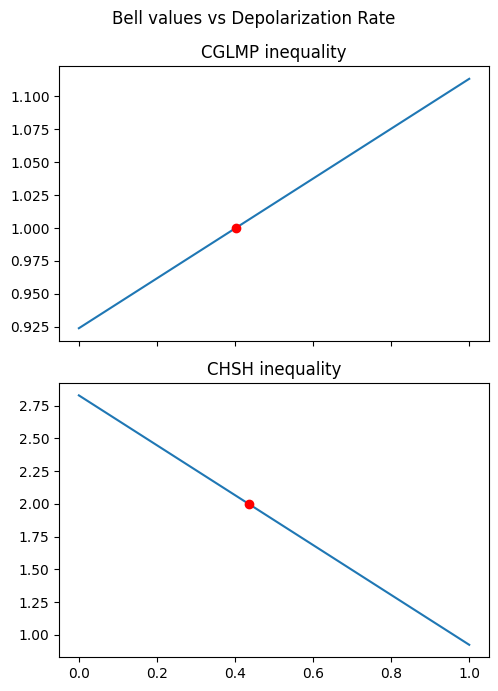

In [13]:
fig, axs = plt.subplots(2,1, figsize=(5, 7), sharex = True)
fig.suptitle('Bell values vs Depolarization Rate')
axs[0].plot(depolarization_rate_list, np.real(CGLMP_Bell_values))
axs[0].set_title("CGLMP inequality")
if CGLMP_robustness.real >=0 and CGLMP_robustness.real <= 1:
    axs[0].plot(CGLMP_robustness.real, 1, 'ro')

axs[1].plot(depolarization_rate_list, np.real(CHSH_Bell_values))
axs[1].set_title("CHSH inequality")
if CHSH_robustness.real >=0 and CHSH_robustness.real <= 1:
    axs[1].plot(CHSH_robustness.real, 2, 'ro')
fig.tight_layout()

print("CHSH Robustness:", CHSH_robustness.real)
print("CGLMP Robustness:", CGLMP_robustness.real)

First, we try the depolarizing channel:
$$
\rho = p\ket{\psi}\bra{\psi} + \frac{1-p}{d^2}\mathbb{I}_d^2
$$
similar to this [paper](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.109.062227) which talks about the robustness of a quantum state to noise with respect to the CGLMP inequality

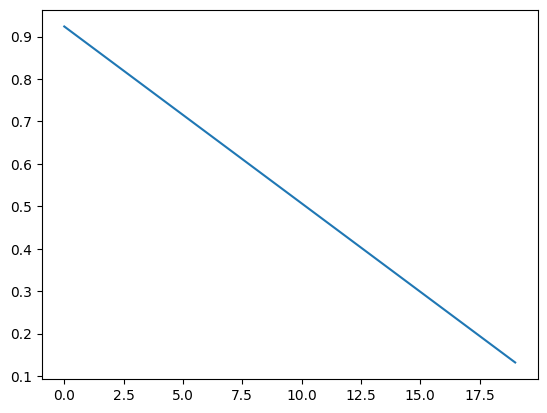

In [17]:
Bell_values = []
depolarization_rate_list = np.linspace(0, 1, 20, endpoint=True)

for depolarization_rate in depolarization_rate_list:
    direct_dm_depol = 0
    ########### Using maximally mixed Bosonic state
    direct_dm_depol = (depolarization_rate) * np.eye(D**4) / (D**4) + (1-depolarization_rate) * bell_dm
    Bell_values.append(np.trace(direct_dm_depol @ bell_op))

plt.plot(np.real(Bell_values))

Next, we perform the same exeriment in two different cases: using the single qubit depolarizing channel on both qubits and the 2 qubit depolarizing channel on both qubits. 


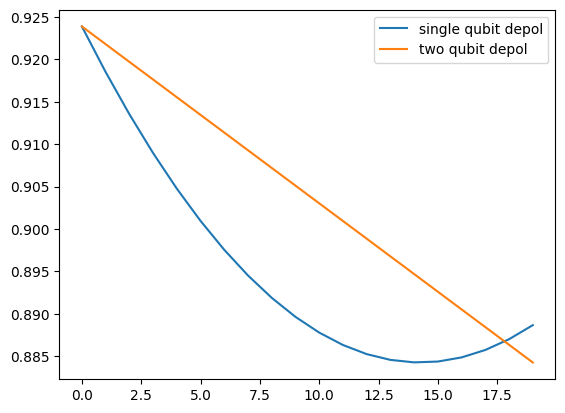

In [19]:
single_Bell_values = []
double_Bell_values = []
depolarization_rate_list = np.linspace(0, 1, 20, endpoint=True)

for depolarization_rate in depolarization_rate_list:

    direct_dm_depol = 0
    ############ Using two qubit depolarizing channel
    depolarizing_kraus_ops = two_qubit_depolarizing_channel(depolarizing_probability = depolarization_rate, N = D)
    for i in depolarizing_kraus_ops:
        direct_dm_depol += i @ bell_dm @ i.conj().T
    double_Bell_values.append(np.trace(direct_dm_depol @ bell_op).real)    

    direct_dm_depol = 0
    ########### Using single qubit depolarizing channel on each qubit
    depolarizing_kraus_ops = depolarizing_operators(depolarization_rate, D)
    for i in depolarizing_kraus_ops:
        for j in depolarizing_kraus_ops:
            depol_op = sp.kron(i, j)
            direct_dm_depol += depol_op @ bell_dm @ depol_op.conj().T
    single_Bell_values.append(np.trace(direct_dm_depol @ bell_op).real)

plt.plot(single_Bell_values, label = "single qubit depol")
plt.plot(double_Bell_values, label = "two qubit depol")
plt.legend()

So, we got some 

We calculate the Bell value for two kinds of mixed states:<br> 
1. Mixed polarization state:
$$
\ket{\psi} = \ket{HH}\bra{HH}+\ket{VH}\bra{VH}+\ket{HV}\bra{HV}+\ket{VV}\bra{VV}
$$
2. Completely mixed bosonic state (Identities over entire Hilbert space)
<br><br>
3. Thermal states in all detectors

In [20]:
# This is only applicable for D=2
mixed_dm = np.zeros((D**4, D**4))
mixed_dm[5][5] = 1/4
mixed_dm[6][6] = 1/4
mixed_dm[9][9] = 1/4
mixed_dm[10][10] = 1/4
print("Mixed polarization state Bell value (Only valid for D=2):", np.trace(mixed_dm @ bell_op))

mixed_dm = np.eye(D**4)/D**4
print("Completely mixed bosonic state Bell value:", np.trace(mixed_dm @ bell_op))

all_mode_thermal_noise = np.kron(two_mode_thermal_noise, two_mode_thermal_noise)
print("Thermal state Bell value:", np.trace(all_mode_thermal_noise @ bell_op))

Mixed polarization state Bell value (Only valid for D=2): (0.6743650115015504+0j)
Completely mixed bosonic state Bell value: (0.13174405855456697+0j)
Thermal state Bell value: (1.1183078851937447+0j)


## Now, we use the measurement operators for observing optimal violation
This has been derived from this [paper](https://iopscience.iop.org/article/10.1088/1751-8113/49/14/145301) (same paper as the inequality)

In [5]:
@lru_cache
def Alice_states(a, x, d, N):
    """
    args:
    a: int (Takes multiple values in Bell operator construction)
        Alice's measurement outcome (label) (0 <= a < d)
    x: int (Takes multiple values in Bell operator construction)
        Index of Alice's measurement setting (0 <= x < N)
    d: int (constant for an experiment)
        Number of outcomes of Alice's measurement
    N: int (constant for an experiment)
        Number of settings of Alice's measurement (number of meas. operators)
    """
    return sum([1/sqrt(d) * np.exp((2j*np.pi/d) * (k*(a+x/N))) * qt.basis(d, k).full() for k in range(d)])

@lru_cache
def Bob_states(b, y, d, N):
    """
    args:
    b: int (Takes multiple values in Bell operator construction)
        Bob's measurement outcome (label) (0 <= b < d)
    y: int (Takes multiple values in Bell operator construction)
        Index of Bob's measurement setting (0 <= y < N)
    d: int (constant for an experiment)
        Number of outcomes of Bob's measurement
    N: int (constant for an experiment)
        Number of settings of Bob's measurement (number of meas. operators)
    """
    return sum([1/sqrt(d) * np.exp((2j*np.pi/d) * (k*(-b+(1-2*y)/(2*N)))) * qt.basis(d, k).full() for k in range(d)])

First, we try it on a standard, qubit Bell state. For this, N=d=2. 

In [9]:
N=2
d=2
D=2

alice_meas_ops = [[Alice_states(a, n, d, N) @ Alice_states(a, n, d, N).T.conj() for a in range(d)] for n in range(N)]
bob_meas_ops = [[Bob_states(b, n, d, N) @ Bob_states(b, n, d, N).T.conj() for b in range(d)] for n in range(N)]
bell_op = generalized_bell_op(d = d, N = N, alice_meas_ops = alice_meas_ops, bob_meas_ops = bob_meas_ops)

bell_state = 1/sqrt(2) * (np.kron(qt.basis(2,0).full(), qt.basis(2,0).full()) + np.kron(qt.basis(2,1).full(), qt.basis(2,1).full()))
bell_dm = bell_state @ bell_state.T.conj()


In [10]:
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.array([[1,0],[0,1]])

def spin_two_qubit_depolarizing_channel(depolarizing_probability, N):
    """This function produces the Kraus operators for the two qubit depolarizing channel.
    
    Args:
        depolarizing_probability (float): The depolarizing probability.
        N (int): local Hilbert space dimension being considered.
    """
    single_qubit_ops = [I, X, Y, Z]
    ops = []
    ops.append(sqrt(1-(15/16)*depolarizing_probability) * np.eye(N**2))
    for i in range(4):
        for j in range(4):
            if i == 0 and j == 0:
                continue
            else:
                ops.append(sqrt(depolarizing_probability/16) * np.kron(single_qubit_ops[i], single_qubit_ops[j]))
    return ops

Bell value: (0.7928932188134521+0j)


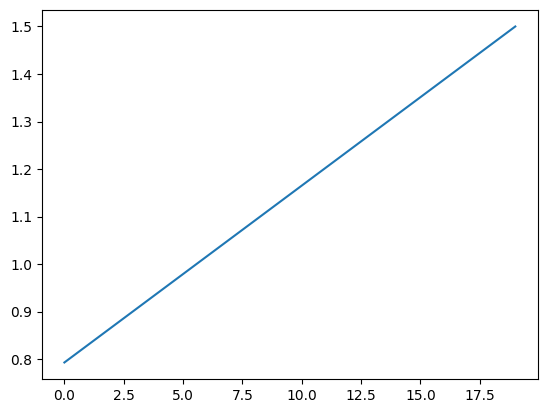

In [11]:
Bell_values = []
depolarization_rate_list = np.linspace(0, 1, 20)

for depolarization_rate in depolarization_rate_list:

    direct_dm_depol = 0
    
    ############ Using two qubit depolarizing channel
    depolarizing_kraus_ops = spin_two_qubit_depolarizing_channel(depolarizing_probability = depolarization_rate, N = D)
    for i in depolarizing_kraus_ops:
        direct_dm_depol += i @ bell_dm @ i.conj().T

    # ########### Using single qubit depolarizing channel on each qubit
    # depolarizing_kraus_ops = depolarizing_operators(depolarization_rate, D)
    # for i in depolarizing_kraus_ops:
    #     for j in depolarizing_kraus_ops:
    #         depol_op = sp.kron(i, j)
    #         direct_dm_depol += depol_op @ bell_dm @ depol_op.conj().T

    Bell_values.append(np.trace(direct_dm_depol @ bell_op)) # calc_CHSH_value(direct_dm, efficiency, N))

plt.plot(Bell_values)
print("Bell value:", np.trace(bell_dm @ bell_op))

We can generalize the above and instead, use an approximately optimal state for CGLMP violation

In [11]:
d = 10
N = d # This could be something else as well, we're just using this. 


alice_meas_ops = [[Alice_states(a, n, d, N) @ Alice_states(a, n, d, N).T.conj() for a in range(d)] for n in range(N)]
bob_meas_ops = [[Bob_states(b, n, d, N) @ Bob_states(b, n, d, N).T.conj() for b in range(d)] for n in range(N)]
bell_op = generalized_bell_op(d = d, N = N, alice_meas_ops = alice_meas_ops, bob_meas_ops = bob_meas_ops)

psi_approx = 0
normalization = 0
N=2
for j in range(d):
    normalization += ((j+1)*(d-j))**(-2/N)

for k in range(d):
    psi_approx += np.kron(qt.basis(d,k).full(), qt.basis(d,k).full()) / ((k+1)*(d-k))**(1/N)

psi_approx = psi_approx / sqrt(normalization)

dm_approx = psi_approx @ psi_approx.T.conj()

print("Bell value:", np.trace(dm_approx @ bell_op))

Bell value: (0.3634279685413756+1.232595164407831e-32j)


# FAFO Cell

In [6]:
D = 2
error_tolerance = 1e-10
read_quantum_state(create_perfect_bell_state(D=D), D, 2)
op = ry(np.pi, D, site1 = 0, site2 = 1, total_sites = 4)
psi = tensor_network_apply_op_vec(op, create_perfect_bell_state(D=D), compress=True, contract = True, cutoff = error_tolerance)
read_quantum_state(psi, D, 2)

POVM_H, POVM_V, POVM_N, POVM_B = create_POVMs(1, 2)
print(POVM_V.toarray())

Corresponding Basis terms:
1H0V_B 1H0V_A - 5 - [0.70710678+0.j]
0H1V_B 0H1V_A - 10 - [0.70710678+0.j]
Corresponding Basis terms:
1H0V_B 0H1V_A - 6 - [-0.70710678+0.j]
0H1V_B 1H0V_A - 9 - [0.70710678+0.j]
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
